#  Finding how to start a Phase injected Topology optimization

In [1]:
import meep as mp
print(mp.__version__)
import meep.adjoint as mpa
import numpy as np
from autograd import numpy as npa
from matplotlib import pyplot as plt
from IPython.display import Video

1.27.0


In [2]:
seed = np.random.randint(100000)
np.random.seed(seed)
mp.verbosity(0)
Si = mp.Medium(index=3.4)
SiO2 = mp.Medium(index=1.44)




waveguide_width = 0.5 # (μm)
waveguide_length = 2 # (μm)
waveguide_thickness = 0.22

arm_separation =waveguide_width+ 0.5 # (μm) distance between arms center to center

pml_size = 1.0 # (μm)
resolution = 50 # (pixels/μm)

In [3]:
minimum_length = 0.09 # (μm)
eta_e = 0.75

eta_i = 0.5
eta_d = 1-eta_e
design_region_resolution = int(resolution) # (pixels/μm)
frequencies = 1/np.linspace(1.5,1.6,5) # (1/μm)


In [4]:
Sx = 2*pml_size + waveguide_length # cell size in X
Sy = 2*pml_size + 2*waveguide_width+ arm_separation +1 # cell size in Y
Sz = 2*pml_size + waveguide_thickness +1 # cell size in Z ###

cell_size = mp.Vector3(Sx,Sy,Sz)

pml_layers = [mp.PML(pml_size)]

fcen = 1/1.55
width = 0.2
fwidth = width * fcen
#source_center  = [-Sx/2 + pml_size + waveguide_length/3,arm_separation/2,0]
source_size    = mp.Vector3(0,waveguide_width+0.5,waveguide_thickness+0.5)###
kpoint = mp.Vector3(1,0,0)

source_center1  = [-Sx/2 + pml_size + 0.1 ,arm_separation/2,0]
source_center2  = [-Sx/2 + pml_size + 0.1,-arm_separation/2,0]

# src = mp.GaussianSource(frequency=fcen,fwidth=fwidth)
# sources = [mp.EigenModeSource(src,
#                     eig_band = 1,
#                     direction=mp.NO_DIRECTION,
#                     eig_kpoint=kpoint,
#                     size = source_size,
#                     center=source_center1,
#                     amplitude=1.0),
#             mp.EigenModeSource(
#                     src,
#                     eig_band=1,
#                     direction=mp.NO_DIRECTION,
#                     eig_kpoint=kpoint,
#                     size=source_size,
#                     center=source_center2,
#                     amplitude=0.0 - 1.0j
#     )]



src = mp.GaussianSource(frequency=fcen,fwidth=fwidth)
source = [mp.EigenModeSource(src,
                    eig_band = 1,
                    direction=mp.NO_DIRECTION,
                    eig_kpoint=kpoint,
                    size = source_size,
                    center=source_center1)]





geometry = [
    mp.Block(center=mp.Vector3(x=0, y=arm_separation/2), material=Si, size=mp.Vector3(Sx+2*pml_size, waveguide_width, waveguide_thickness)), # top left waveguide
    mp.Block(center=mp.Vector3(x=0, y=-arm_separation/2), material=Si, size=mp.Vector3(Sx, waveguide_width, waveguide_thickness)), # bottom left waveguide

]

sim = mp.Simulation(cell_size=cell_size,
                    boundary_layers=pml_layers,
                    geometry=geometry,
                    sources=source,
                    #symmetries=[mp.Mirror(direction=mp.Y)],
                    default_material=SiO2,
                    resolution=resolution)

  

<Axes: xlabel='X', ylabel='Y'>

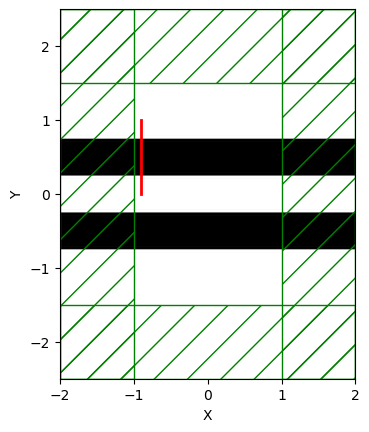

In [5]:
sim.plot2D(
    output_plane = mp.Volume(
        center = mp.Vector3(z=0),
        size = mp.Vector3(x=Sx,y=Sy)
    ))

<Axes: xlabel='X', ylabel='Z'>

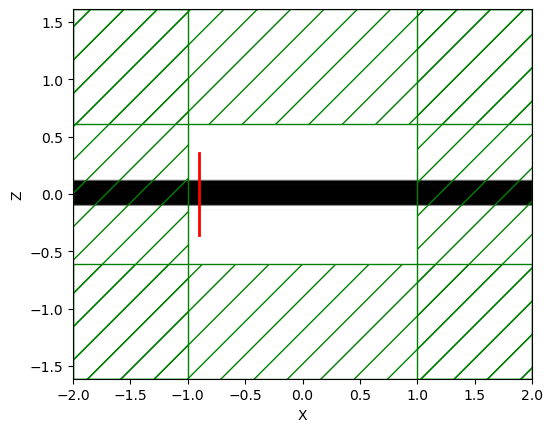

In [6]:
sim.plot2D(
    output_plane = mp.Volume(
        center = mp.Vector3(y=arm_separation/2),
        size = mp.Vector3(x=Sx,z=Sz)))

<Axes: xlabel='Y', ylabel='Z'>

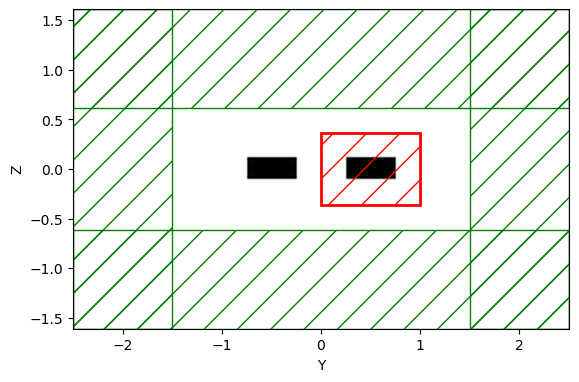

In [7]:
sim.plot2D(
    output_plane = mp.Volume(
        center = mp.Vector3(x=-Sx/2 + pml_size + 0.1),
        size = mp.Vector3(y=Sy, z=Sz)
    ))

In [8]:
sim.run(until=100)


FloatProgress(value=0.0, description='0% done ')

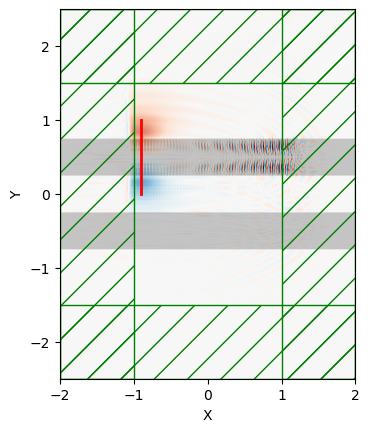

In [9]:
plt.figure(dpi=100)
sim.plot2D(fields= mp.Ez,
    output_plane = mp.Volume(
        center = mp.Vector3(z=0),
        size = mp.Vector3(x=Sx,y=Sy, z=0)
    ))
plt.show()

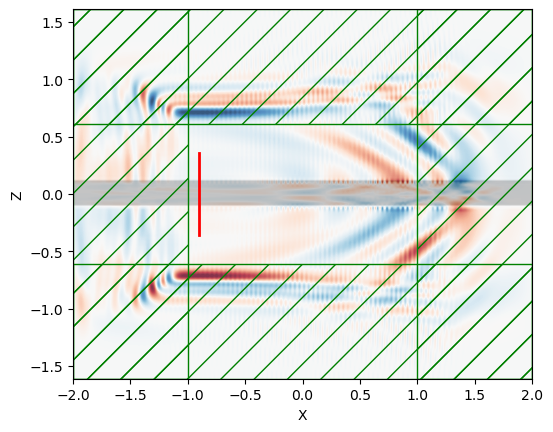

In [11]:
plt.figure(dpi=100)
sim.plot2D(fields= mp.Ez,
    output_plane = mp.Volume(
        center = mp.Vector3(y=arm_separation/2),
        size = mp.Vector3(x=Sx,z=Sz)))
plt.show()

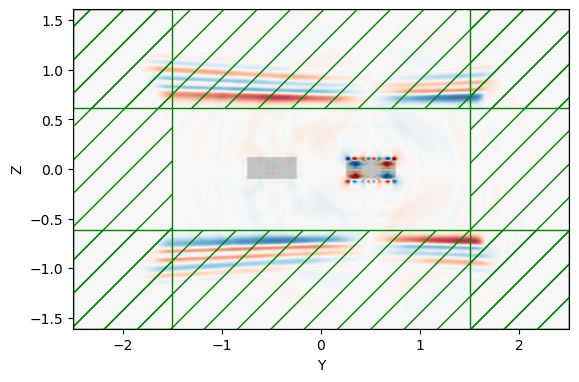

In [12]:
plt.figure(dpi=100)
sim.plot2D(fields= mp.Ez,
    output_plane = mp.Volume(
        center = mp.Vector3(x=0.01), ## if x=0 then its the mid point hence no waveguide
        size = mp.Vector3(y=Sy, z=Sz)
    ))
plt.show()

In [ ]:
flux_reg = mp.FluxRegion(direction=mp.Z, center=mp.Vector3(), size=mp.Vector3(0,waveguide_width+0.5,waveguide_thickness+0.5))
wvg_flux = sim.add_flux(fcen, 0, 1, flux_reg)

force_reg1 = mp.ForceRegion(mp.Vector3(0.49*s), direction=mp.X, weight=1, size=mp.Vector3(y=sy))
force_reg2 = mp.ForceRegion(mp.Vector3(0.5*s+1.01*a), direction=mp.X, weight=-1, size=mp.Vector3(y=sy))
wvg_force = sim.add_force(fcen, 0, 1, force_reg1, force_reg2)

sim.run(until_after_sources=1500)

In [ ]:
sim.reset_meep()
f = plt.figure(dpi=100)
Animate = mp.Animate2D(fields=mp.Ez, f=f, realtime=False, normalize=True)
plt.close()

In [ ]:
sim.run(mp.at_every(1, Animate), until=300)
plt.close()

In [ ]:
filename = "straignt_waveguides.mp4"
Animate.to_mp4(10, filename)

In [ ]:
Video(filename)


## Reference images

With amplitude = 1.0 + 0.0j

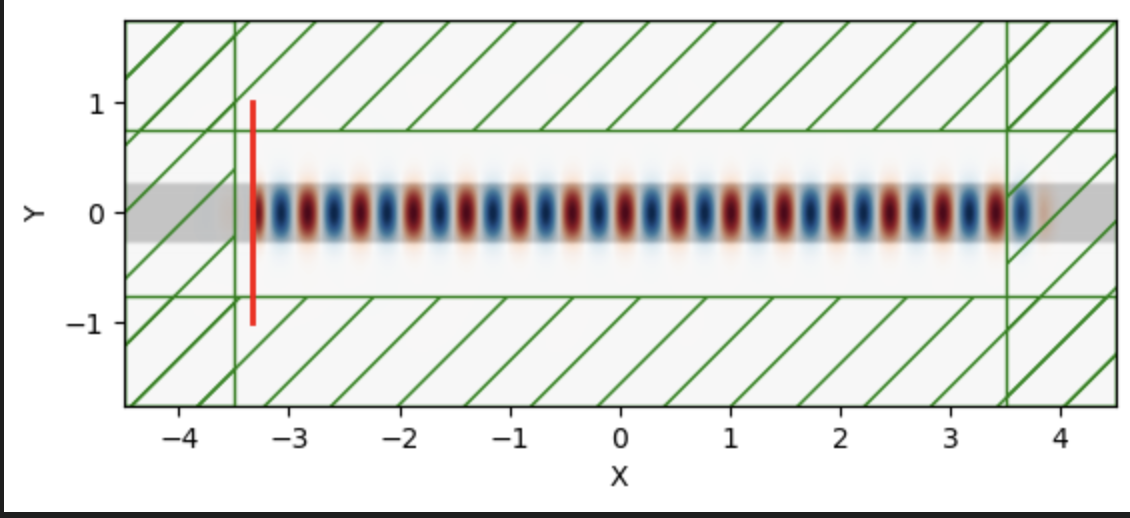

With amplitude= -1.0 + 0.0j

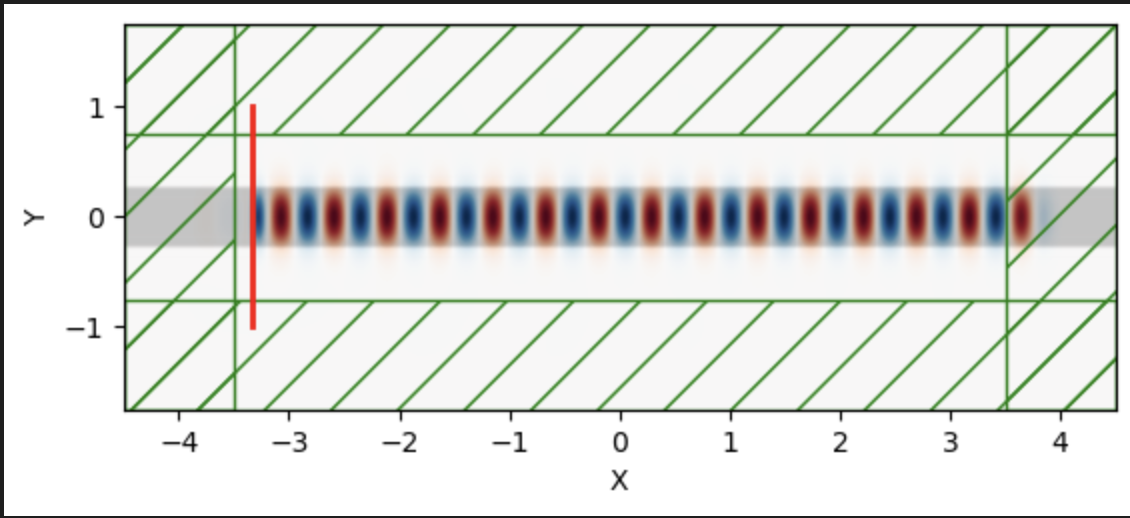

With amplitude= 0.0 + 1.0j

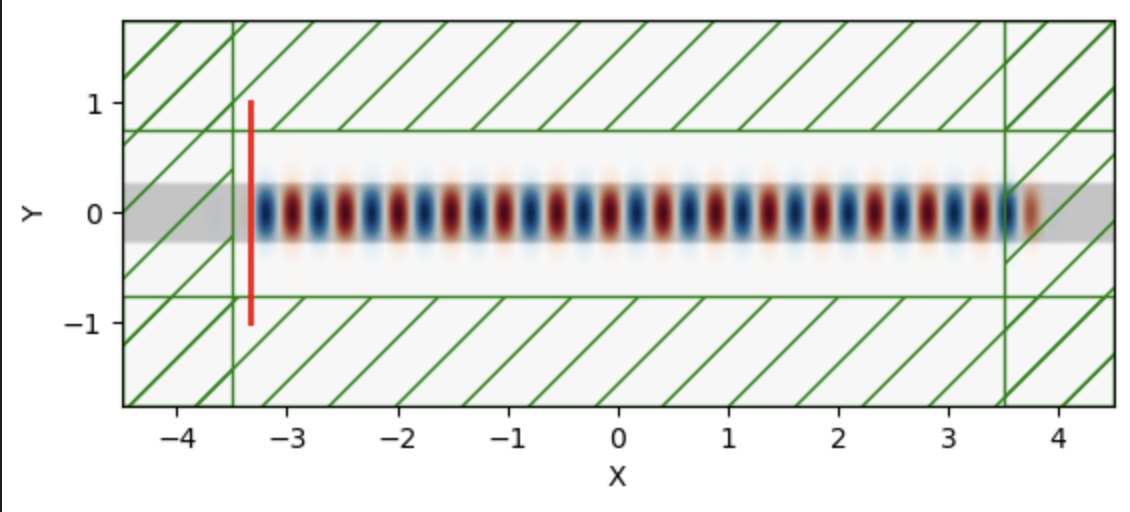

With amplitude= 0.0 - 1.0j

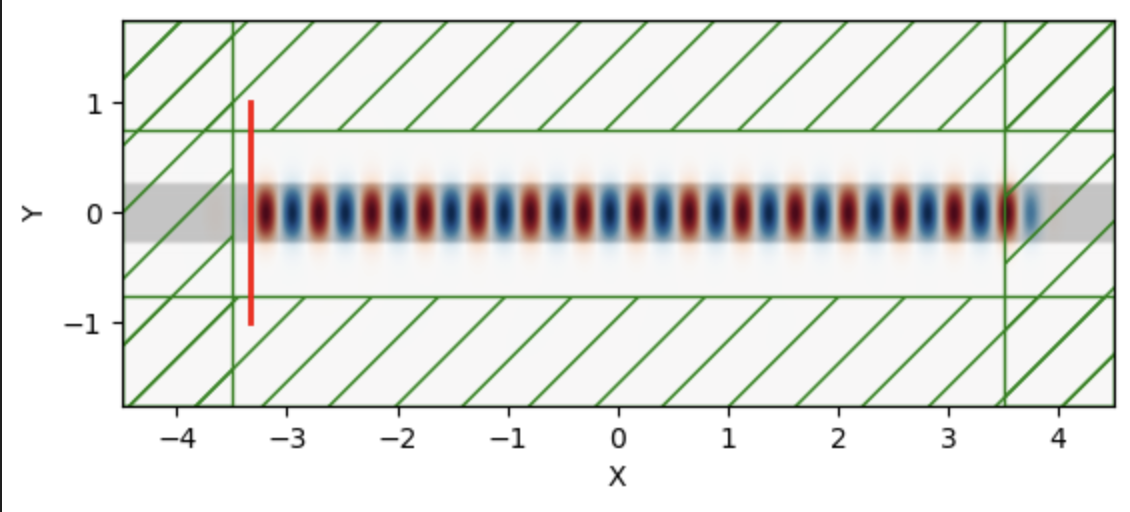